In [1]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.distance import pdist, squareform
from torch_geometric.data import Data
from itertools import combinations

In [8]:
# === Paramètres ===
DATA_ROOT = Path("defi-mod-ia-2025")
XYZ_DIR = DATA_ROOT / "atoms" / "train"
ENERGY_CSV = DATA_ROOT / "energies" / "train.csv"

# === Lecture des energies ===
energy_df = pd.read_csv(ENERGY_CSV)
energy_df['id'] = "id_" + energy_df['id'].astype(str)
id_to_energy = dict(zip(energy_df['id'], energy_df['energy']))

print(f"Nombre de molecules : {len(energy_df)}")
print(energy_df['id'])

Nombre de molecules : 6591
0          id_1
1          id_2
2          id_3
3          id_4
4          id_5
         ...   
6586    id_6587
6587    id_6588
6588    id_6589
6589    id_6590
6590    id_6591
Name: id, Length: 6591, dtype: object


In [9]:
# === Fonction de chargement .xyz ===
def load_xyz(filepath):
    atom_types = []
    positions = []
    with open(filepath, 'r') as f:
        lines = f.readlines()[2:]  # sauter les 2 premières lignes
        for line in lines:
            parts = line.split()
            atom_types.append(parts[0])
            positions.append([float(x) for x in parts[1:4]])
    return atom_types, torch.tensor(positions, dtype=torch.float32)

In [13]:
# === Encodage simple des atomes ===
element_map = {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4, 'Cl': 5, 'S' : 1}  # à compléter si besoin
def encode_atoms(atom_types):
    return torch.tensor([element_map[a] for a in atom_types], dtype=torch.long).unsqueeze(1)

# === Construction d'un graphe simple ===
def build_graph(file_id):
    xyz_path = XYZ_DIR / f"{file_id}.xyz"
    atom_types, pos = load_xyz(xyz_path)
    x = encode_atoms(atom_types)

    edge_index = []
    for i, j in combinations(range(len(pos)), 2):
        dist = torch.norm(pos[i] - pos[j])
        if dist < 1.6:  # seuil de liaison covalente
            edge_index.append([i, j])
            edge_index.append([j, i])
    if edge_index:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)

    y = torch.tensor([id_to_energy[file_id]], dtype=torch.float32)
    return Data(x=x, edge_index=edge_index, pos=pos, y=y, id=file_id)

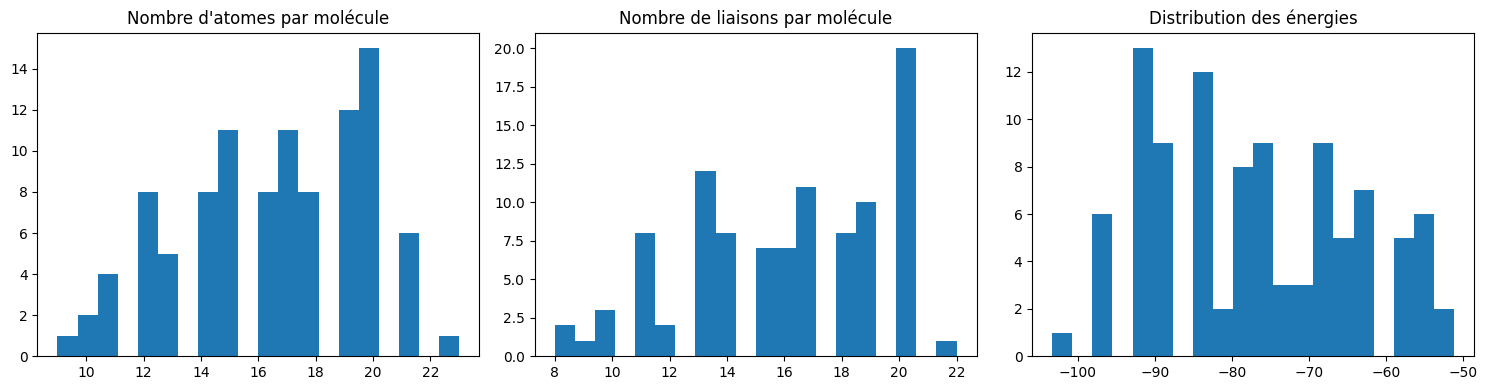

In [14]:
# === Chargement de quelques molecules ===
sample_ids = energy_df['id'].sample(100, random_state=42).tolist()
data_list = [build_graph(file_id) for file_id in sample_ids]

# === Statistiques ===
n_atoms = [data.x.size(0) for data in data_list]
n_edges = [data.edge_index.size(1) // 2 for data in data_list]  # arêtes bidirectionnelles
energies = [data.y.item() for data in data_list]

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(n_atoms, bins=20)
plt.title("Nombre d'atomes par molécule")

plt.subplot(1, 3, 2)
plt.hist(n_edges, bins=20)
plt.title("Nombre de liaisons par molécule")

plt.subplot(1, 3, 3)
plt.hist(energies, bins=20)
plt.title("Distribution des énergies")

plt.tight_layout()
plt.show()

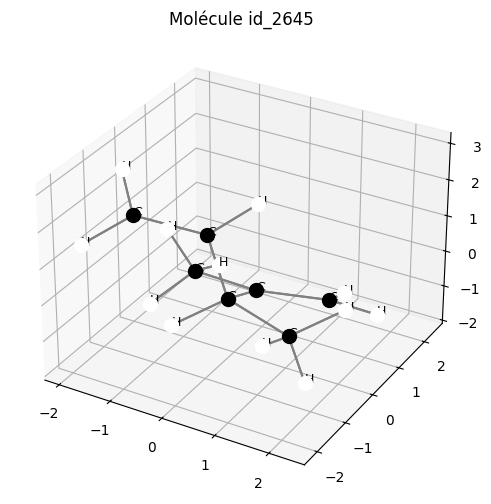

In [15]:
# === Visualisation 3D simple d'une molécule ===
from mpl_toolkits.mplot3d import Axes3D

def visualize_molecule_3d(data):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['white', 'black', 'blue', 'red', 'green', 'purple']
    pos = data.pos.numpy()
    for i, (x, y, z) in enumerate(pos):
        at = data.x[i].item()
        ax.scatter(x, y, z, color=colors[at], s=100)
        ax.text(x, y, z, list(element_map.keys())[at], fontsize=9)
    for i, j in data.edge_index.t().tolist():
        pi, pj = pos[i], pos[j]
        ax.plot([pi[0], pj[0]], [pi[1], pj[1]], [pi[2], pj[2]], 'gray')
    ax.set_title(f"Molécule {data.id}")
    plt.show()

# Visualiser une molécule au hasard
visualize_molecule_3d(data_list[0])